In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Generating dataset...
Dataset generated: 43613 samples

Training models...
Training KNN...
Training Decision Tree...
Training Naive Bayes...
Training Random Forest...
Training Extra Trees...
Training AdaBoost...
Training Gradient Boosting...

MODEL PERFORMANCE COMPARISON
            Model  Accuracy  Precision   Recall  F1-Score
Gradient Boosting  0.975543   0.975399 0.975543  0.975416
         AdaBoost  0.975161   0.975040 0.975161  0.975053
      Naive Bayes  0.975161   0.975040 0.975161  0.975053
              KNN  0.974702   0.974546 0.974702  0.974561
    Random Forest  0.952461   0.952429 0.952461  0.952445
      Extra Trees  0.952308   0.952324 0.952308  0.952316
    Decision Tree  0.952308   0.952304 0.952308  0.952306

Best Model: Gradient Boosting
Best F1-Score: 0.9754

CLASSIFICATION REPORT - Gradient Boosting
              precision    recall  f1-score   support

     Jamming       1.00      1.00      1.00      5258
      Normal       0.93      0.90      0.92      1994
     

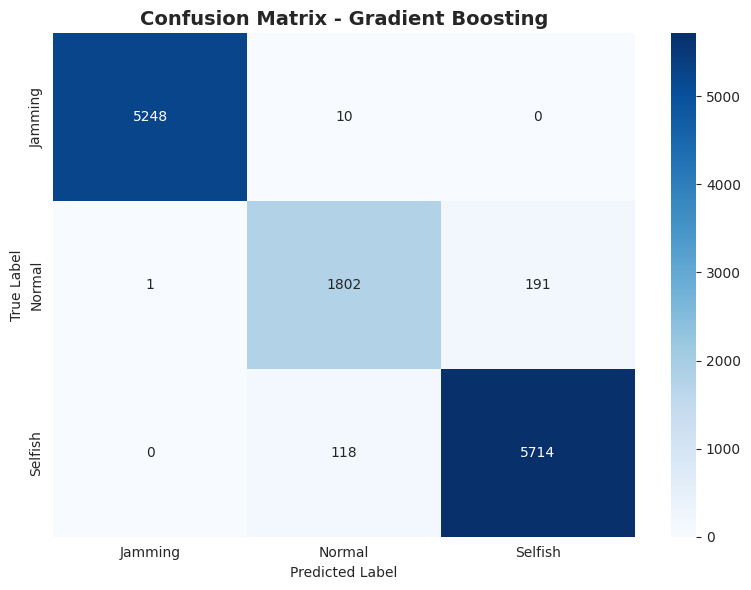

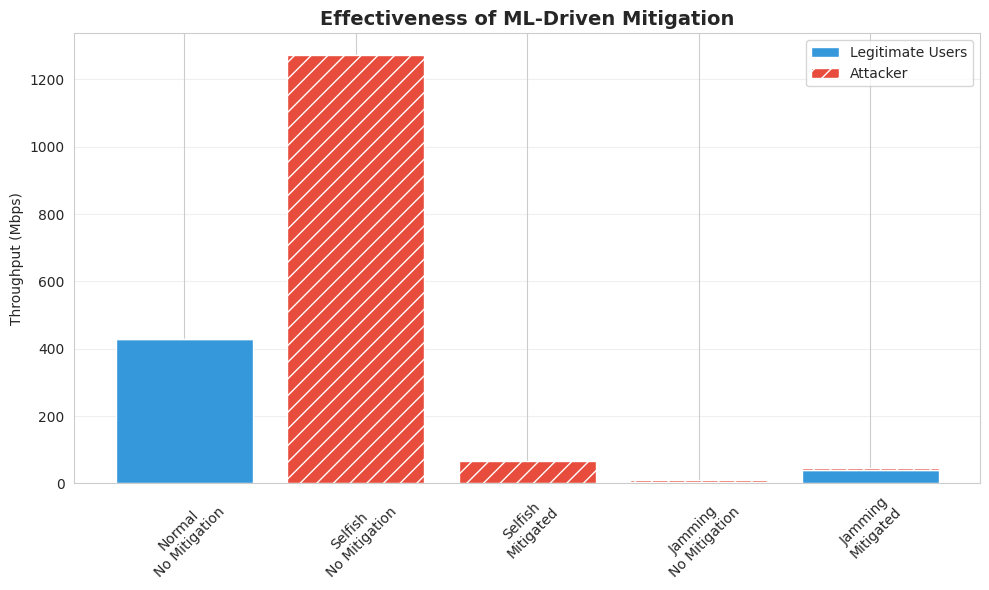

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from collections import deque
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style("whitegrid")

# ============================================================
# 1. NETWORK CONFIGURATION & FEATURE LIST
# ============================================================

FEATURES = [
    "Queuing_Delay",
    "Transmission_Time",
    "Propagation_Delay",
    "Total_Packet_Travelling_Time",
    "isContinuouslyOccupied",
    "Payload_Size"
]

SLOT_TIME = 9e-6          
DATA_RATE = 54e6          
DATA_RATE_ROBUST = 11e6   
PAYLOAD_NORMAL = 1460     
PAYLOAD_JAMMING = 8       
CW_MIN = 15
CW_MAX = 1023
AP_BLACKLIST_DROP_PROB = 0.95 
JAMMING_SURVIVAL_PROB = 0.9
TOTAL_NODES = 10

# ============================================================
# 2. WIRELESS NODE CLASS
# ============================================================

class WirelessNode:
    def __init__(self, node_id, is_attacker=False, attack_type=None):
        self.node_id = node_id
        self.is_attacker = is_attacker
        self.attack_type = attack_type

        self.cw_min = CW_MIN
        self.cw_max = CW_MAX
        self.cw = self.cw_min
        self.backoff = np.random.randint(0, self.cw + 1)
        self.state = "IDLE"
        
        self.is_blacklisted = False

    def step(self, channel_busy):
        action = "WAIT"

        if self.is_attacker:
            if self.attack_type == "Selfish":
                # RUTHLESS: Never wait. Always try to grab the channel.
                if self.backoff <= 0:
                    action = "TRANSMIT"
                else:
                    self.backoff -= 1
            
            elif self.attack_type == "Jamming":
                if np.random.rand() > 0.1: 
                    action = "TRANSMIT"
        else:
            # Normal DCF Behavior
            if self.state == "IDLE":
                if not channel_busy:
                    if self.backoff <= 0:
                        action = "TRANSMIT"
                        self.state = "TRANSMITTING"
                    else:
                        self.backoff -= 1
        
        return action

    def handle_outcome(self, outcome):
        if self.is_attacker and self.attack_type == "Selfish":
            self.backoff = 0
            self.state = "IDLE"
            return

        if outcome == "SUCCESS":
            self.state = "IDLE"
            self.cw = self.cw_min
            self.backoff = np.random.randint(0, self.cw + 1)
        
        elif outcome == "COLLISION":
            self.state = "IDLE"
            self.cw = min(self.cw * 2, self.cw_max)
            self.backoff = np.random.randint(0, self.cw + 1)

# ============================================================
# 3. DATASET GENERATION
# ============================================================

def generate_dataset(scenario, duration_slots=20000):
    nodes = []
    for i in range(TOTAL_NODES):
        attacker = False; a_type = None
        if scenario == "Selfish" and i == 0: attacker = True; a_type = "Selfish"
        elif scenario == "Jamming" and i == TOTAL_NODES - 1: attacker = True; a_type = "Jamming"
        nodes.append(WirelessNode(i, attacker, a_type))

    logs = []
    prev_winner = -1
    
    for _ in range(duration_slots):
        actions = [n for n in nodes if n.step(False) == "TRANSMIT"]
        
        if len(actions) == 1:
            node = actions[0]
            
            # Feature calculation
            q = node.cw * SLOT_TIME * 1e6
            pkt = PAYLOAD_JAMMING if (node.is_attacker and scenario == "Jamming") else PAYLOAD_NORMAL
            tx = (pkt * 8) / DATA_RATE
            prop = np.random.uniform(1, 3)
            
            logs.append({
                "Scenario_Label": scenario,
                "Queuing_Delay": q,
                "Transmission_Time": tx * 1e6,
                "Propagation_Delay": prop,
                "Total_Packet_Travelling_Time": q + (tx*1e6) + prop,
                "isContinuouslyOccupied": 1 if node.node_id == prev_winner else 0,
                "Payload_Size": pkt
            })
            prev_winner = node.node_id
            node.handle_outcome("SUCCESS")
            
        elif len(actions) > 1:
            prev_winner = -1
            for n in actions: n.handle_outcome("COLLISION")
            
    return pd.DataFrame(logs)

print("Generating dataset...")
df = pd.concat([
    generate_dataset("Normal"),
    generate_dataset("Selfish"),
    generate_dataset("Jamming")
], ignore_index=True)
df.fillna(0, inplace=True)
print(f"Dataset generated: {len(df)} samples")

# ============================================================
# 4. TRAINING & SELECTING BEST MODEL
# ============================================================

X = df[FEATURES]
y = df["Scenario_Label"]
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42)

print("\nTraining models...")

models_dict = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []
trained_models = {}

for name, model in models_dict.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })
    trained_models[name] = model

# Display Comparison Table
res_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(res_df.to_string(index=False))
print("="*80)

best_model_name = res_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]
best_f1 = res_df.iloc[0]["F1-Score"]

print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {best_f1:.4f}")

# Detailed Report for Best Model
y_pred_best = best_model.predict(X_test)

print("\n" + "="*80)
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=le.classes_))
print("="*80)

# --- CONFUSION MATRIX (SHOWN RIGHT AFTER CLASSIFICATION REPORT) ---
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
# plt.show() # Uncomment to show plot in window

# ============================================================
# 5. ONLINE SIMULATION WITH MITIGATION
# ============================================================

def simulate_network(scenario, enable_mitigation=False):
    nodes = []
    for i in range(TOTAL_NODES):
        attacker = False; a_type = None
        if scenario == "Selfish" and i == 0: attacker = True; a_type = "Selfish"
        elif scenario == "Jamming" and i == TOTAL_NODES - 1: attacker = True; a_type = "Jamming"
        nodes.append(WirelessNode(i, attacker, a_type))

    # Metric Counters
    legit_bytes = 0
    attacker_bytes = 0
    
    # Mitigation State
    mitigation_active = False
    conf_window = deque(maxlen=25)
    prev_winner = -1
    detected_attacker_id = -1
    
    DURATION = 20000 
    
    for slot in range(DURATION):
        
        # 1. Gather Intentions
        tx_nodes = [n for n in nodes if n.step(False) == "TRANSMIT"]
        
        # 2. Process Outcome
        if len(tx_nodes) == 1:
            node = tx_nodes[0]
            
            # --- MITIGATION LOGIC: AP POLICING ---
            packet_dropped_by_ap = False
            if mitigation_active and scenario == "Selfish" and node.node_id == detected_attacker_id:
                if np.random.rand() < AP_BLACKLIST_DROP_PROB:
                    packet_dropped_by_ap = True
            
            # --- DETECTION LOGIC ---
            if enable_mitigation and not mitigation_active:
                q = node.cw * SLOT_TIME * 1e6
                tx_time = (PAYLOAD_NORMAL * 8) / DATA_RATE
                
                features = pd.DataFrame([{
                    "Queuing_Delay": q,
                    "Transmission_Time": tx_time * 1e6,
                    "Propagation_Delay": 2.0,
                    "Total_Packet_Travelling_Time": q + (tx_time*1e6) + 2.0,
                    "isContinuouslyOccupied": 1 if node.node_id == prev_winner else 0,
                    "Payload_Size": PAYLOAD_NORMAL 
                }], columns=FEATURES)
                
                prob = best_model.predict_proba(features)[0]
                conf_window.append(np.max(prob))
                
                # Trigger Mitigation
                if len(conf_window) >= 15 and np.mean(conf_window) > 0.75:
                    pred_idx = np.argmax(prob)
                    pred_label = le.classes_[pred_idx]
                    
                    if pred_label == "Selfish":
                        mitigation_active = True
                        detected_attacker_id = prev_winner 
                        print(f"  [Sim:{scenario}] MITIGATION: AP Blacklisting Node {detected_attacker_id}")
                    elif pred_label == "Jamming":
                        mitigation_active = True
                        print(f"  [Sim:{scenario}] MITIGATION: Switching to Robust Coding (AP Blacklisting Node 9)")

            # --- HANDLE SUCCESS ---
            prev_winner = node.node_id
            node.handle_outcome("SUCCESS")
            
            # --- RECORD THROUGHPUT ---
            if not packet_dropped_by_ap:
                pkt_size = PAYLOAD_JAMMING if (node.is_attacker and scenario=="Jamming") else PAYLOAD_NORMAL
                if node.is_attacker:
                    attacker_bytes += pkt_size
                else:
                    legit_bytes += pkt_size

        elif len(tx_nodes) > 1:
            # --- COLLISION LOGIC ---
            survivors = []
            
            # JAMMING MITIGATION (Robust Mode)
            if mitigation_active and scenario == "Jamming":
                for n in tx_nodes:
                    if not n.is_attacker:
                        if np.random.rand() < JAMMING_SURVIVAL_PROB:
                            survivors.append(n)
                            
            if len(survivors) == 1:
                # Recovery Success
                node = survivors[0]
                node.handle_outcome("SUCCESS")
                prev_winner = node.node_id
                
                # Penalty: Robust data rate is slower
                rate_ratio = DATA_RATE_ROBUST / DATA_RATE
                legit_bytes += (PAYLOAD_NORMAL * rate_ratio)
            else:
                prev_winner = -1
                for n in tx_nodes: n.handle_outcome("COLLISION")

    total_time = DURATION * SLOT_TIME
    return {
        'Legit_Mbps': (legit_bytes * 8) / total_time / 1e6,
        'Attacker_Mbps': (attacker_bytes * 8) / total_time / 1e6
    }

# ============================================================
# 6. EXECUTION & VISUALIZATION
# ============================================================

print("\nRunning Simulations...")

results_sim = []

# 1. Normal
res = simulate_network("Normal", False)
results_sim.append({"Scenario": "Normal", "Type": "No Mitigation", "Legit": res['Legit_Mbps'], "Attacker": res['Attacker_Mbps']})

# 2. Selfish No Mit
res = simulate_network("Selfish", False)
results_sim.append({"Scenario": "Selfish", "Type": "No Mitigation", "Legit": res['Legit_Mbps'], "Attacker": res['Attacker_Mbps']})

# 3. Selfish Mitigated
res = simulate_network("Selfish", True)
results_sim.append({"Scenario": "Selfish", "Type": "Mitigated", "Legit": res['Legit_Mbps'], "Attacker": res['Attacker_Mbps']})

# 4. Jamming No Mit
res = simulate_network("Jamming", False)
results_sim.append({"Scenario": "Jamming", "Type": "No Mitigation", "Legit": res['Legit_Mbps'], "Attacker": res['Attacker_Mbps']})

# 5. Jamming Mitigated
res = simulate_network("Jamming", True)
results_sim.append({"Scenario": "Jamming", "Type": "Mitigated", "Legit": res['Legit_Mbps'], "Attacker": res['Attacker_Mbps']})

df_res = pd.DataFrame(results_sim)

print("\n" + "="*80)
print("FINAL THROUGHPUT REPORT (Mbps)")
print("="*80)
print(df_res[["Scenario", "Type", "Legit", "Attacker"]].round(2).to_string(index=False))
print("="*80)

# Final Bar Chart
plt.figure(figsize=(10, 6))
labels = [f"{r['Scenario']}\n{r['Type']}" for _, r in df_res.iterrows()]
legit_vals = df_res['Legit']
attack_vals = df_res['Attacker']

# Bar chart with stacked values for better comparison
plt.bar(labels, legit_vals, label='Legitimate Users', color='#3498db')
plt.bar(labels, attack_vals, bottom=legit_vals, label='Attacker', color='#e74c3c', hatch='//')

plt.title('Effectiveness of ML-Driven Mitigation', fontsize=14, fontweight='bold')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('fixed_mitigation_results.png')
print("\nCharts saved as 'confusion_matrix.png' and 'fixed_mitigation_results.png'")